### pitstop dataset

build a pitstop dataset across all the oval races

+ gap distribution analysis. (normal pit .vs. pit in caution laps)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"

## Load Data

In [2]:
import os
os.getcwd()

'/scratch/hpda/indycar/predictor/notebook/8.PitStopAnalysis'

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
#https://www.racing-reference.info/season-stats/2018/O/#
events_totalmiles=[256,500,372,268,500,310]
events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
events_id={key:idx for idx, key in enumerate(events)}
#events = ['Indy500']
#events = ['Phoenix']

In [4]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
    
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    
    return df

def make_lapstatus_data(dataset):
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)
    
    #pick up one of them
    onecar = dataset[dataset['car_number']==completed_car_numbers[0]]
    onecar = onecar.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    return onecar[['completed_laps','track_status']]
    

In [5]:
def load_data(event, year):
    inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
    outputprefix = year +'-' + event + '-'
    dataset = pd.read_csv(inputfile)
    #dataset.info(verbose=True)    
    
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)

    #make a copy
    alldata = dataset.copy()
    dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
    rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    cldata = make_cl_data(dataset)
    flagdata = make_lapstatus_data(dataset)
    acldata = make_cl_data(alldata)

    return alldata, rankdata, acldata, flagdata

### overall view of laptime scatter plots



In [6]:
def get_cardata(curcarno, ycol='time_diff'):
    car = acldata[acldata['car_number']==curcarno]
    #print(car['time_diff'].describe())
    
    cols=['completed_laps','rank','car_number','lap_status','track_status',
    'pit_stop_count','current_status','start_position']
    colid={key:idx for idx, key in enumerate(cols)}

    cardata = rankdata[rankdata['car_number'] == curcarno]

    carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
        ['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']].values]
    
    x = car['completed_laps'][1:].values
    y = car[ycol][1:].values

    pits=[]
    yellowflags=[]
    lastflag = 'x'
    for row in carstatus:
        lap = int(row[colid['completed_laps']])

        if row[colid['lap_status']]=='P':
            pits.append(lap)

        if row[colid['track_status']]=='Y':
            if lastflag != 'Y':       
                #start
                yellowflags.append(lap)
        else:
            if lastflag == 'Y':       
                #end
                yellowflags.append(lap)        
        lastflag = row[colid['track_status']]

    #pit lap
    pits = np.array(pits)
    #start, end lap
    #
    yellowflags = np.array(yellowflags)
    if (yellowflags.shape[0] % 2)==1:
        print('crash?:carno=', curcarno)
        yellowflags = []
    else:
        yellowflags = np.array(yellowflags).reshape((-1,2))    
    
    return car, x, y, pits, yellowflags

### bulid the dataset

In [7]:
def get_stagedata(TRIM=2):
    """
    input: acldata, rankdata, the whole dataset
    output: stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank']
    """
    carlist = set(acldata['car_number'])
    data = []
    for curcarno in carlist:
        car = acldata[acldata['car_number']==curcarno]
        #print(car['time_diff'].describe())

        cols=['completed_laps','rank','car_number','lap_status','track_status',
        'pit_stop_count','current_status','start_position']
        colid={key:idx for idx, key in enumerate(cols)}

        cardata = rankdata[rankdata['car_number'] == curcarno]

        carstatus = [[row[0], row[1],row[2],row[3],row[4],row[5],row[6],row[7]] for row in cardata[
            ['completed_laps','rank','car_number','lap_status','track_status',
            'pit_stop_count','current_status','start_position']].values]

        pits=[]
        yellowflags=[]
        lastflag = 'x'
        
        stage = 0
        start_lap = 0
        pit_lap = -1
        pit_in_caution = 0
        for row in carstatus:
            lap = int(row[colid['completed_laps']])
            
            if lap==0:
                #hex2int
                start_rank = int(row[colid['start_position']], 16)     
            
            if row[colid['lap_status']]=='P' and row[colid['current_status']]=='Active':
                pits.append(lap)
                end_lap = lap - TRIM
                end_rank = carstatus[end_lap][colid['rank']]
                
                pit_lap = lap  #current is pit lap
                pit_in_caution = 1 if row[colid['track_status']]=='Y' else 0
                #add one record
                #stagedata['car_number','stage','start_lap','end_lap','start_rank','end_rank']
                data.append([curcarno,stage,start_lap, end_lap, pit_lap, pit_in_caution, start_rank, end_rank])
                # prepare for the next
                stage += 1
                start_lap = end_lap  # end_lap + 1?
                start_rank = end_rank
                

            if row[colid['track_status']]=='Y':
                if lastflag != 'Y':       
                    #start
                    yellowflags.append(lap)
            else:
                if lastflag == 'Y':       
                    #end
                    yellowflags.append(lap)        
            lastflag = row[colid['track_status']]

        #final
        end_lap = carstatus[-1][colid['completed_laps']]
        end_rank = carstatus[-1][colid['rank']]
        #add one record
        #stagedata['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
        #data.append([curcarno,stage,start_lap, end_lap, pit_lap, pit_in_caution, start_rank, end_rank])
        
        #pit lap
        pits = np.array(pits)
        #start, end lap
        #
        yellowflags = np.array(yellowflags)
        if (yellowflags.shape[0] % 2)==1:
            print('crash?:carno=', curcarno)
            yellowflags = []
        else:
            yellowflags = np.array(yellowflags).reshape((-1,2))  
            
    data = np.array(data)
    #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution,'start_rank','end_rank']
    df = pd.DataFrame({'car_number': data[:, 0], 'stage': data[:, 1],'start_lap': data[:, 2],
                      'end_lap': data[:, 3], 'pit_lap': data[:, 4], 'pit_in_caution': data[:, 5],
                       'start_rank': data[:, 6],'end_rank': data[:, 7]})
    return df, data

### events

In [8]:
def extract_features(stagedata):
    """
    input: (alldata, rankdata, acldata, flagdata, stage, data)
    
    target
    eventid
    car_number
    stageid
    
    #0, gobal info 
    firststage  ;  1/0    
    pit_in_caution; 1/0
    start_position  ; #
    
    # 0 order of #rank
    start_rank  ;  #rank
    start_rank_ratio; ; #rank/carnum 
    top_pack    ;  top5 1/0 
    bottom_pack  ; bottom5 1/0 
    
    average_rank  ; previous stage
    average_rank_all  ; all previous stages
    
    # 1 order of #rank
    change_in_rank; previous stage
    change_in_rank_all;  all previous stages
    # 2 order of #rank
    rate_of_change; previous stage
    rate_of_change_all;  all previous stages
    
    #neighbors;   
    prev_nb0_change_in_rank
    prev_nb1_change_in_rank
    prev_nb2_change_in_rank
    follow_nb0_change_in_rank
    follow_nb1_change_in_rank
    follow_nb2_change_in_rank
    
    """
    eventid = 0
    cols=['target','start_lap',
             'eventid','car_number','stageid',
             'firststage','pit_in_caution','start_position',
             'start_rank','start_rank_ratio','top_pack','bottom_pack',
             'average_rank','average_rank_all',
             'change_in_rank','change_in_rank_all','rate_of_change','rate_of_change_all',
             'prev_nb0_change_in_rank','prev_nb1_change_in_rank','prev_nb2_change_in_rank',
             'follow_nb0_change_in_rank','follow_nb1_change_in_rank','follow_nb2_change_in_rank']
    colid={key:idx for idx, key in enumerate(cols)}
    
    datacols = ['car_number','stage','start_lap','end_lap','pit_lap', 'pit_in_caution', 'start_rank','end_rank']
    datacolid={key:idx for idx, key in enumerate(datacols)}
    
    #maintain a <car,lap, (rank, stage)> index 
    idxcols = ['car_number','completed_laps','rank','stageid']
    carindex = {}
    
    stagedf = pd.DataFrame([],columns=cols)
    for event in stagedata.keys():
        alldata, rankdata, acldata, flagdata, stage, data = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        totalcars = len(carlist)
        totallaps = len(laplist)

        # init the index
        #carindex[eventid] = np.array((totalcars, totallaps, 2))
        carindex[eventid] = pd.DataFrame([],columns=idxcols)
        
        records = []
        
        laphist = []
        rankhist = []
        rankchghist = []        
        #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution, 'start_rank','end_rank']
        for row in data:
            # a new record
            rec={}
            #status, 'start_lap', start a new car
            if row[datacolid['start_lap']] == 0:
                start_position = row[datacolid['start_rank']]
                laphist = []
                rankhist = []
                rankchghist = []
            
            #target 
            rec['target'] = row[datacolid['end_rank']] - row[datacolid['start_rank']]
            rec['start_lap'] = row[datacolid['start_lap']]
            
            #features
            rec['eventid'] = eventid
            rec['car_number'] = row[datacolid['car_number']]
            rec['stageid'] = row[datacolid['stage']]
            rec['firststage'] = 0 if row[datacolid['stage']]==0 else 1
            rec['pit_in_caution'] = row[datacolid['pit_in_caution']]
            rec['start_position'] = start_position
            rec['start_rank'] = row[datacolid['start_rank']]
            rec['start_rank_ratio'] = rec['start_rank'] / totalcars
            rec['top_pack'] = 1 if rec['start_rank']<=5 else 0
            #todo, not accurate here
            rec['bottom_pack'] = 1 if rec['start_rank']>=totalcars-5 else 0
            #get from laphist
            if laphist:
                #previous stage
                prev_stage = laphist[-1]
                rec['average_rank'] = np.mean(list(prev_stage['rank']))
                rec['average_rank_all'] = np.mean(rankhist)
            else:
                rec['average_rank'] = rec['start_rank']
                rec['average_rank_all'] = rec['start_rank']
                
            #change in rank
            if rankchghist:
                rec['change_in_rank'] = rankchghist[-1]
                rec['change_in_rank_all'] = np.mean(rankchghist)
            else:
                rec['change_in_rank'] = 0
                rec['change_in_rank_all'] = 0
                
            #rate of change in rank
            if len(rankchghist)>2:
                rec['rate_of_change'] = rankchghist[-1] - rankchghist[-2]
                rec['rate_of_change_all'] = (rankchghist[-1] - rankchghist[0])/(len(rankchghist)-1)
            else:
                rec['rate_of_change'] = 0
                rec['rate_of_change_all'] = 0            
                
            # init neighbor info as 0
            rec['prev_nb0_change_in_rank'] = 0
            rec['prev_nb1_change_in_rank'] = 0
            rec['prev_nb2_change_in_rank'] = 0
            rec['follow_nb0_change_in_rank'] = 0
            rec['follow_nb1_change_in_rank'] = 0
            rec['follow_nb2_change_in_rank'] = 0
            

                
            
            #add one record
            records.append([rec[col] for col in cols])
            
            #update for the new stage
            lapdata = rankdata[(rankdata['car_number']== rec['car_number']) & 
                               (rankdata['completed_laps']>=row[datacolid['start_lap']]) &
                               (rankdata['completed_laps']<row[datacolid['end_lap']])
                              ]
            laphist.append(lapdata)
            rankhist.extend(list(lapdata['rank']))
            rankchghist.append(row[datacolid['end_rank']] - row[datacolid['start_rank']])
            
            # add to index, go through the lapdata
            #or _lap in range(row[datacolid['start_lap']],row[datacolid['end_lap']]):
            for index, row in lapdata.iterrows():
                #carindex[eventid][rec['car_number'], row['completed_laps'], 0] = row['rank']
                #carindex[eventid][rec['car_number'], row['completed_laps'], 1 = rec['stageid']
                laprec = [rec['car_number'], row['completed_laps'], row['rank'],rec['stageid']]
                df = pd.DataFrame([laprec],columns=idxcols)
                carindex[eventid] = pd.concat([carindex[eventid], df], ignore_index=True)
            
          
        # push this event into stage dataframe
        print('eventid=%d, records=%d'%(eventid, len(records)))
        df = pd.DataFrame(records,columns=cols)
        stagedf = pd.concat([stagedf, df], ignore_index=True)
        
        #for the next new event
        eventid += 1
        
    return stagedf, carindex

def update_neighbor(stagedf, carindex):
    # go through stage data to add neighbor info
    # carindex[eventid] <car, lap, (rank, stage)
    ndf = stagedf.copy()
    
    #stagedf.index = pd.RangeIndex(len(stagedf.index))
        
    for index, row in stagedf.iterrows():
        
        eventid = row['eventid']
        
        currank = row['start_rank']
        curlap = row['start_lap']
        if curlap == 0:
            continue
        
        df = carindex[row['eventid']]
        df_lap = df[df['completed_laps']==curlap]
        prev0 = df_lap[df_lap['rank'] == currank - 1]
        prev1 = df_lap[df_lap['rank'] == currank - 2]
        prev2 = df_lap[df_lap['rank'] == currank - 3]
        follow0 = df_lap[df_lap['rank'] == currank + 1]
        follow1 = df_lap[df_lap['rank'] == currank + 2]
        follow2 = df_lap[df_lap['rank'] == currank + 3]
        
        recs = [prev0, prev1, prev2, follow0, follow1,follow2]
        recloc = ['prev_nb0_change_in_rank','prev_nb1_change_in_rank','prev_nb2_change_in_rank',
                 'follow_nb0_change_in_rank','follow_nb1_change_in_rank','follow_nb2_change_in_rank']
        for recidx, rec in enumerate(recs):
            if rec.empty:
                continue
                
            car_number = rec['car_number']
            stageid = rec['stageid']
            #print('event:%d, car:%d, stage:%d, index:%d'%(eventid, car_number, stageid, index))
            #find the record of prev0 by eventid, carno, stageid
            #neighbor = stagedf[(stagedf['eventid'] == eventid) & (stagedf['car_number'] == car_number) & (stagedf['stageid'] == stageid)]
            #neighbor = ndf[(ndf['eventid'] == eventid) & (ndf['car_number'] == car_number) & (ndf['stageid'] == stageid)]
            neighbor = ndf.query('eventid == %d & car_number==%d & stageid==%d'%(eventid,car_number,stageid))
            
            if neighbor.empty:
                print('error: empty neighbor at: '%(eventid,car_number,stageid))
                continue
            
            # update current row
            #print('index=%d, col=%s'%(index, recloc[recidx]))
            stagedf.loc[index,recloc[recidx]] = neighbor['change_in_rank'].values[0]
            #stagedf.loc[index,recloc[recidx]] = 1
                                
    return stagedf

def extract_stint_features(stagedata):
    """
    input: (alldata, rankdata, acldata, flagdata, stage, data)
    
    lap_distance    ; lap distance for this stint
    eventid
    car_number
    stageid
    
    pit_in_caution; 1/0
    start_position  ; #
    start_rank  ;  #rank
    end_rank
    """
    #eventid = 0
    cols=['lap_distance','start_lap','pit_lap',
             'eventid','car_number','stageid',
             'pit_in_caution','start_position',
             'start_rank', 'end_rank']
    colid={key:idx for idx, key in enumerate(cols)}
    
    datacols = ['car_number','stage','start_lap','end_lap','pit_lap', 'pit_in_caution', 'start_rank','end_rank']
    datacolid={key:idx for idx, key in enumerate(datacols)}
    
    #maintain a <car,lap, (rank, stage)> index 
    idxcols = ['car_number','completed_laps','rank','stageid']
    carindex = {}
    
    stagedf = pd.DataFrame([],columns=cols)
    for event in stagedata.keys():
        
        eventid = events_id[event]
        
        alldata, rankdata, acldata, flagdata, stage, data = stagedata[event]
        carlist = set(acldata['car_number'])
        laplist = set(acldata['completed_laps'])
        totalcars = len(carlist)
        totallaps = len(laplist)

        # init the index
        #carindex[eventid] = np.array((totalcars, totallaps, 2))
        carindex[eventid] = pd.DataFrame([],columns=idxcols)
        
        records = []
        
        laphist = []
        rankhist = []
        rankchghist = []        
        #['car_number','stage','start_lap','end_lap',pit_lap, pit_in_caution, 'start_rank','end_rank']
        for row in data:
            # a new record
            rec={}
            #status, 'start_lap', start a new car
            if row[datacolid['start_lap']] == 0:
                start_position = row[datacolid['start_rank']]
                laphist = []
                rankhist = []
                rankchghist = []
            
            #target 
            rec['lap_distance'] = row[datacolid['end_lap']] - row[datacolid['start_lap']] + 1
            rec['start_lap'] = row[datacolid['start_lap']]
            rec['pit_lap'] = row[datacolid['pit_lap']]
            
            #features
            rec['eventid'] = eventid
            rec['car_number'] = row[datacolid['car_number']]
            rec['stageid'] = row[datacolid['stage']]
            
            rec['pit_in_caution'] = row[datacolid['pit_in_caution']]
            rec['start_position'] = start_position
            rec['start_rank'] = row[datacolid['start_rank']]
            rec['end_rank'] = row[datacolid['end_rank']]
            
            
            #add one record
            records.append([rec[col] for col in cols])
            
            #update for the new stage
            lapdata = rankdata[(rankdata['car_number']== rec['car_number']) & 
                               (rankdata['completed_laps']>=row[datacolid['start_lap']]) &
                               (rankdata['completed_laps']<row[datacolid['end_lap']])
                              ]
            laphist.append(lapdata)
            rankhist.extend(list(lapdata['rank']))
            rankchghist.append(row[datacolid['end_rank']] - row[datacolid['start_rank']])
            
            # add to index, go through the lapdata
            #or _lap in range(row[datacolid['start_lap']],row[datacolid['end_lap']]):
            for index, row in lapdata.iterrows():
                #carindex[eventid][rec['car_number'], row['completed_laps'], 0] = row['rank']
                #carindex[eventid][rec['car_number'], row['completed_laps'], 1 = rec['stageid']
                laprec = [rec['car_number'], row['completed_laps'], row['rank'],rec['stageid']]
                df = pd.DataFrame([laprec],columns=idxcols)
                carindex[eventid] = pd.concat([carindex[eventid], df], ignore_index=True)
            
          
        # push this event into stage dataframe
        print('eventid=%d, records=%d'%(eventid, len(records)))
        df = pd.DataFrame(records,columns=cols)
        stagedf = pd.concat([stagedf, df], ignore_index=True)
        
        #for the next new event
        #eventid += 1
        
    return stagedf, carindex

### load data

In [9]:
stagedata = {}
traindata = None
for event in events:
    #alldata, rankdata, acldata, flagdata
    stagedata[event] = load_data(event, year)
    
    alldata, rankdata, acldata, flagdata = stagedata[event]
    carlist = set(acldata['car_number'])
    laplist = set(acldata['completed_laps'])
    print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))
    
    stage, data = get_stagedata(0)
    stagedata[event] = (alldata, rankdata, acldata, flagdata, stage, data)
    
    if traindata is None:
        traindata = data
    else:
        traindata = np.vstack((traindata, data))

('count of completed cars:', 11)
('completed cars:', array([ 1,  6, 27,  9, 28,  5, 20, 14, 15, 22, 30]))
('cars:', set([1, 5, 6, 9, 14, 15, 20, 22, 27, 28, 30]))
('#cars=', 11)
('count of completed cars:', 11)
('completed cars:', array([ 1,  6, 27,  9, 28,  5, 20, 14, 15, 22, 30]))
('cars:', set([1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 32, 59, 88, 98]))
('#cars=', 23)


/scratch/hpda/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Phoenix: carno=23, lapnum=251
('crash?:carno=', 10)
('crash?:carno=', 19)
('count of completed cars:', 18)
('completed cars:', array([12, 20,  9, 27, 28, 22, 29,  1,  6, 15, 66, 98,  4, 88, 25, 60, 64,
       23]))
('cars:', set([64, 1, 66, 4, 6, 9, 12, 98, 15, 60, 20, 22, 23, 88, 25, 27, 28, 29]))
('#cars=', 18)
('count of completed cars:', 18)
('completed cars:', array([12, 20,  9, 27, 28, 22, 29,  1,  6, 15, 66, 98,  4, 88, 25, 60, 64,
       23]))
('cars:', set([1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98]))
('#cars=', 33)
Indy500: carno=33, lapnum=201
('crash?:carno=', 3)
('crash?:carno=', 24)
('crash?:carno=', 33)
('count of completed cars:', 9)
('completed cars:', array([ 9, 22, 27,  5, 28, 15, 30, 18, 10]))
('cars:', set([5, 9, 10, 15, 18, 22, 27, 28, 30]))
('#cars=', 9)
('count of completed cars:', 9)
('completed cars:', array([ 9, 22, 27,  5, 28, 15, 30, 18, 10]))
('cars:', set([1, 3, 4, 5, 6, 7,

In [10]:
stintdf, carindex = extract_stint_features(stagedata)

eventid=3, records=83
eventid=0, records=89
eventid=1, records=189
eventid=4, records=104
eventid=5, records=83
eventid=2, records=95


In [11]:
#stagedf0.reset_index(inplace=True)
#stagedf = update_neighbor(stagedf0, carindex) 

In [12]:
#stintdf = stintdf.drop(columns=['start_lap'])

In [13]:
stintdf.to_csv('stint-%s.csv'%year)

In [14]:
#rankdata[rankdata['car_number']==12]
#[['completed_laps','last_laptime','track_status']]

In [15]:
set(rankdata[rankdata['car_number']==12]['last_pitted_lap'])

{'0', '3E', '78', 'B1', 'E7'}

### pitstop analysis

In [26]:
def get_distance_data(car_number):
    """
    events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
    """
    car = stintdf[stintdf['car_number']==car_number]
    
    normal_pits = car[car['pit_in_caution']==0][['eventid','lap_distance']].to_numpy()
    normal_laplen = [events_laplen[x[0]]*x[1] for x in normal_pits]
    
    caution_pits = car[car['pit_in_caution']==1][['eventid','lap_distance']].to_numpy()
    caution_laplen = [events_laplen[x[0]]*x[1] for x in caution_pits]
    
    #plot it
    return normal_laplen,caution_laplen


In [19]:
normal_pits = car12[car12['pit_in_caution']==0]
normal_pits
data = normal_pits[['eventid','lap_distance']].to_numpy()
data

array([[3, 80],
       [3, 77],
       [0, 82],
       [0, 30],
       [1, 33],
       [1, 45],
       [1, 36],
       [1, 43],
       [4, 32],
       [4, 34],
       [4, 33],
       [4, 34],
       [4, 35],
       [5, 63],
       [5, 59],
       [5, 55],
       [2, 64],
       [2, 57]], dtype=object)

In [23]:
data = normal_pits[['eventid','lap_distance']].to_numpy()
laplen = [events_laplen[x[0]]*x[1] for x in data]

In [22]:
for event in stagedata.keys():
    print event, events_id[event]

Iowa 3
Phoenix 0
Indy500 1
Pocono 4
Gateway 5
Texas 2


(array([1., 0., 0., 0., 3., 2., 8., 2., 0., 2.]),
 array([ 30.66 ,  38.844,  47.028,  55.212,  63.396,  71.58 ,  79.764,
         87.948,  96.132, 104.316, 112.5  ]),
 <a list of 10 Patch objects>)

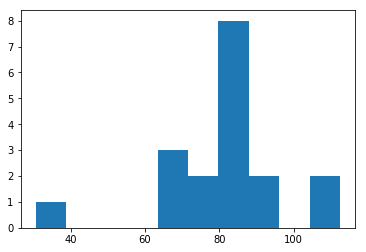

In [27]:
nlap, clap = get_distance_data(12)
plt.hist(nlap)

(array([1., 0., 0., 2., 0., 1., 1., 0., 0., 1.]),
 array([22.5 , 29.85, 37.2 , 44.55, 51.9 , 59.25, 66.6 , 73.95, 81.3 ,
        88.65, 96.  ]),
 <a list of 10 Patch objects>)

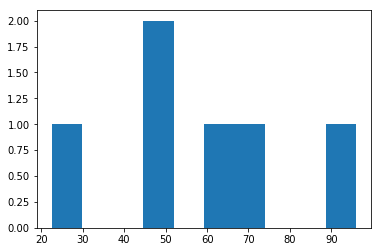

In [28]:
plt.hist(clap)